In [40]:
# update_db.py
import os
import pandas as pd
import sqlalchemy as sql
from sqlalchemy.sql.schema import Column
from sqlalchemy.sql.sqltypes import String
import shutil

# print("file path:", os.getcwd()) # root should in ./tdtoolkit_web
raw_root = os.path.join('.','src','app', 'raw')

path = {
    "axo": os.path.join(raw_root, "AXO"),
    "rdl": os.path.join(raw_root, "RDL"),
    "opt": os.path.join(raw_root, "OPT"),
    "rt": os.path.join(raw_root, "RT"),
    "cond": os.path.join(raw_root, "CONDITIONS"),
    "prop": os.path.join(raw_root, "PROPERTY"),
    "ref": os.path.join(raw_root, "REF"),
    "output": "output",
    "db": "database"
}

# need to separate later
def axo_load(path, cond=pd.DataFrame()):
    """
    The path and the file name need to be below:
    Could be multiple file
    ─┬─ folder[path]
     ├─ 1-1 + 1-2 + 1-3.csv
     ├─ 1-4.csv
     ...
    """
    df = pd.DataFrame()
    # may wrong, need caution
    loc = [5, 3, 1, 6, 4, 2]
    for cwd, dir_name, file_names in os.walk(path):
        for f in file_names:
            file = os.path.join(cwd, f)
            # get short-id from file name
            # Cause there may be multiple panel in one file, we need to
            # deal with it.
            short_id = f.split(".")[0]
            short_id = [s.strip() for s in short_id.split("+")]
            # multiple each point 6 times cause there are 6 point in one panel
            # maybe I should split this function to another place?
            short_id_6 = [id for id in short_id for _ in range(6)]
            location_6 = loc * len(short_id)
            # Todo: more error format handling
            
            tmp_df = pd.read_csv(file, engine="python", skiprows=27, skipfooter=92)
            tmp_df.insert(loc = 1, column = "short-id", value=short_id_6)
            tmp_df.insert(loc = 2, column = "point", value = location_6)
            # some data has different title(?), so we rename it to make concat well 
            tmp_df.columns = ["Chip No.", "Short-id",  "Point", "x", "y", "cell gap", "top rubbing direct", "twist", "top pre-tilt", "bottom pre-tilt", "rms", "iteration"]
            df = pd.concat([df, tmp_df], ignore_index=True)
    # replace short-id if you have condition table
    if cond.empty != True:
        df = df.rename(columns={"Short-id": "ID", "Chip No.": "LC"})
        df["ID"] = df["ID"].map(dict(cond[["Short-id", "ID"]].values))
        df["LC"] = df["ID"].map(dict(cond[["ID", "LC"]].values))
        df["Project"] = df["ID"].map(dict(cond[["ID", "Project"]].values))
        df["Batch"] = df["ID"].map(dict(cond[["ID", "Batch"]].values))
        # neglect the data that doesn't record
        df = df[~df["ID"].isna()]
        df.columns = ["LC", "ID", "Point", "x", "y", "cell gap", "top rubbing direct", "twist", "top pre-tilt", "bottom pre-tilt", "rms", "iteration", "Project", "Batch"]

    return df

def rdl_load(path, cond=pd.DataFrame()):
    """
    The path and the file name need to be below:
    Should be single file.
    ─┬─ folder[path]
     └─ [cell gap].xlsx
    """
    file = next(os.walk(path))[2][0]
    df = pd.read_excel(os.path.join(path, file))
    if cond.empty != True:
        df = df.rename(columns={"Short-id": "ID"})
        df["ID"] = df["ID"].map(dict(cond[["Short-id", "ID"]].values))
        df["LC"] = df["ID"].map(dict(cond[["ID", "LC"]].values))
        df["Project"] = df["ID"].map(dict(cond[["ID", "Project"]].values))
        df["Batch"] = df["ID"].map(dict(cond[["ID", "Batch"]].values))
        # neglect the data that doesn't record
        df = df[~df["ID"].isna()]
        df.columns = ['ID', 'cell gap', 'LC', "Project", "Batch"]
    return df

def opt_load(path, cond=pd.DataFrame()):
    """
    The path and the file name need to be below:
    Could be multiple file
    ─┬─ folder[path]
     ├─ xxxx.csv
     ├─ xxxx.csv
     ...
    """
    df = pd.DataFrame()
    for cwd, dir_name, file_names in os.walk(path):
        for f in file_names:
            if f[0] == ".":
                continue
            if f[0] == "~":
                continue
            file = os.path.join(cwd, f)
            tmp_df = pd.read_csv(file, encoding="ansi").iloc[:,:64]
            # some data preprocessing
            df = pd.concat([df, tmp_df], ignore_index=True)
            
    df.columns = ['Data', 'M_Time', 'ID', 'Point', 'Station', 'Operator', 'Voltage',
        'I.Time', 'AR_T%(⊥)', 'AR_T%(//)', 'LCM_X%', 'LCM_Y%', 'LCM_Z%', 'RX',
        'RY', 'RZ', 'GX', 'GY', 'GZ', 'BX', 'BY', 'BZ', 'WX', 'WY', 'WZ', 'CG%',
        'R_x', 'R_y', 'G_x', 'G_y', 'B_x', 'B_y', 'W_x', 'W_y', 'RX_max',
        'GY_max', 'BZ_max', 'V_RX_max', 'V_GY_max', 'V_BZ_max', "WX'", "WY'",
        "WZ'", "W_x'"," W_x'.1", 'LCM_X%max', 'LCM_Y%max', 'LCM_Z%max',
        'φ_(Ymax)', 'φ_(Ymax).1', 'φ_(Zmax)', 'φ_tol_X', 'φ_tol_Y', 'φ_tol_Z',
        'T0/Tmax_X', 'T0/Tmax_Y', 'T0/Tmax_Z', 'Vcri_X', 'Vcri_Y', 'Vcri_Z',
        'dφ_X', 'dφ_Y', 'dφ_Z', "LC"]
    # voltage == 1 is the wrong rows, need drop
    df = df[df["Voltage"] != 1]
    if cond.empty != True:
        df["LC"] = df["ID"].map(dict(cond[["ID", "LC"]].values))
        df["Project"] = df["ID"].map(dict(cond[["ID", "Project"]].values))
        df["Batch"] = df["ID"].map(dict(cond[["ID", "Batch"]].values))
    return df

def rt_load(path, cond=pd.DataFrame()):
    """
    The path and the file name need to be below:
    Could be multiple file
    ─┬─ folder[path]
     ├─ xxxx.txt
     ├─ xxxx.txt
     ...
    """
    df = pd.DataFrame()
    for cwd, dir_name, file_names in os.walk(path):
        for f in file_names:
            if f[0] == ".":
                continue
            if f[0] == "~":
                continue
            file = os.path.join(cwd, f)
            tmp_df = pd.read_table(file, encoding="ansi")
            # some system encoding would go wrong, so I rename here
            # there are some implicit problem, the data should just like this
            tmp_df.columns = ['Date', 'Time', 'ID', 'Point', 'Station', 'Operator', 'cell pos.', 'Target Vpk',
               'Initial Vpk', 'OD_Rise', 'OD_fall', 'Normalized_V', 'Specific_target',
               'Photo Sensor', 'TempSensor', 'Temp', 'Model', 'Rise-mean (10-90)',
               'Rise-stdev (10-90)', 'Fall-mean (10-90)', 'Fall-stdev (10-90)',
               'Rise-mean (5-95)', 'Rise-stdev (5-95)', 'Fall-mean (5-95)',
               'Fall-stdev (5-95)', 'Vcom', 'Flicker', 'Base lv-mean', 'Top lv-mean',
               'WXT (%)', 'BXT (%)', 'WXT_*', 'BXT_*', 'Overshooting or not',
               'Overshooting %', 'TailTime', 'overshooting_peak', 'overshooting_top',
               '(RisePeak-top)/top', '(FallPeak-base)/base', 'delta_peak', 'delta_v',
               'delta_m', 'c_a', 'peak', 'top', 'HLH_(Peak-Top)', 'HLH_area']
            # neglect incorrect rows
            tmp_df = tmp_df[tmp_df["Point"].isin([1, 2, 3, 4, 5, 6, '1', '2', '3', '4', '5', '6'])]
            # correct the data types
            for col in tmp_df.columns:
                try:
                    tmp_df[col] = tmp_df[col].astype('float')
                except:
                    continue
            df = pd.concat([df, tmp_df], ignore_index=True)
    
    if cond.empty != True:
        df["LC"] = df["ID"].map(dict(cond[["ID", "LC"]].values))
        df["Project"] = df["ID"].map(dict(cond[["ID", "Project"]].values))
        df["Batch"] = df["ID"].map(dict(cond[["ID", "Batch"]].values))
    df = df[df["ID"]!="NAN"]
    
    return df

def cond_load(path):
    """
    The path and the file name need to be below:
    Should be single file.
    ─┬─ folder[path]
     └─ [cond].xlsx
    """
    file = next(os.walk(path))[2][0]
    df = pd.read_excel(os.path.join(path, file))
    df = df.iloc[:,0:5]
    df.columns = ["ID", "LC", "Short-id", "Project", "Batch"]
    return df

def prop_load(path):
    """
    The path and the file name need to be below:
    Should be single file.
    ─┬─ folder[path]
     └─ [prop].xlsx
    """
    file = next(os.walk(path))[2][0]
    df = pd.read_excel(os.path.join(path, file))
    df['Scatter index'] = (df['n_e'] ** 2 - df['n_o'] ** 2) ** 2 * 3 / (df['K11(pN)'] + df['K22(pN)'] + df['K33(pN)'])
    df['RT index'] = df['rotation viscosity (γ1)(mPa⋅s)'] / df['K22(pN)']
    return df

def ref_load(path):
    """
    The path and the file name need to be below:
    Should be single file.
    ─┬─ folder[path]
     └─ [ref].xlsx
    """
    file = next(os.walk(path))[2][0]
    df = pd.read_excel(os.path.join(path, file))
    return df

# loading data from raw
cond = cond_load(path["cond"])
axo = axo_load(path["axo"], cond)
rdl = rdl_load(path["rdl"], cond)
opt = opt_load(path["opt"], cond)
rt = rt_load(path["rt"], cond)
prop = prop_load(path["prop"])
ref = ref_load(path["ref"])


# writing to database

engine = sql.create_engine('sqlite:///database/test.db', echo=False)
# engine = sql.create_engine('sqlite://', echo=True)

# meta = sql.MetaData()
# # Model 是否要分出去?
# sql.Table(
#     "cond", meta,
#     sql.Column("LC", sql.String),
#     sql.Column("Short-id", sql.String),
#     sql.Column("ID", sql.String, unique=True),
#     sql.Column("Project", sql.String),
#     sql.Column("Batch", sql.String)
# )

# meta.create_all(engine)

## check constrain

try:
    cond.to_sql("cond", con=engine, if_exists="append", index=False)
    axo.to_sql("axo", con=engine, if_exists="append", index=False)
    rdl.to_sql("rdl", con=engine, if_exists="append", index=False)
    opt.to_sql("opt", con=engine, if_exists="append", index=False)
    rt.to_sql("rt", con=engine, if_exists="append", index=False)
    prop.to_sql("prop", con=engine, if_exists="append", index=False)
    ref.to_sql("ref", con=engine, if_exists="append", index=False)
    print("Database update!")
    shutil.rmtree(raw_root)
except:
    print("Something wrong, maybe the ID condition is duplicate. Database keep")

Something wrong, maybe the ID condition is duplicate. Database keep


In [ ]:
# calculate_summary.py

In [8]:
import sys, os, shutil
import numpy as np
import pandas as pd
import sqlalchemy as sql
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn import linear_model
import matplotlib.pyplot as plt


In [2]:
# just for test, need automation
batch = "RD11006008" # X50
# batch = "RD11001105" # 1098 TR2

engine = sql.create_engine('sqlite:///database/test.db', echo=False)

cond = pd.read_sql(f"SELECT * FROM cond WHERE batch == \"{batch}\"", engine)
axo = pd.read_sql(f"SELECT * FROM axo WHERE batch == \"{batch}\"", engine)
rdl = pd.read_sql(f"SELECT * FROM rdl WHERE batch == \"{batch}\"", engine)
opt = pd.read_sql(f"SELECT * FROM opt WHERE batch == \"{batch}\"", engine)
rt = pd.read_sql(f"SELECT * FROM rt WHERE batch == \"{batch}\"", engine)
prop = pd.read_sql(f"SELECT * FROM prop", engine)
ref = pd.read_sql(f"SELECT * FROM ref WHERE batch == \"{batch}\"", engine)


In [3]:
# remove all files in img
folder = './img/'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [14]:
# plot aux function
def tex_math_str(coef, var, precise=2):
    if len(coef) != (len(var) + 1):
        print('coeff should have one more feature than var')
        return 'error len'
    result = '$' + str(np.round(coef[0],precise))
    for i in range(len(var)):
        if np.round(coef[1+i],precise) == 0:
            continue
        item = str(np.round(coef[1+i],precise)) + var[i]
        if coef[1+i] < 0:
            result += item
        else:
            result += (' + ' + item)
    result += '$'
    return result

def aux_plot(data, LC, xyz, model, var_names, precise=2):
    xlabel = xyz[0]
    ylabel = xyz[1]
    zlabel = xyz[2]
    coeff = model.steps[2][1].coef_
    X = data[[xlabel, ylabel]].to_numpy()
    y = data[zlabel].to_numpy()
    R2_score = model.score(X,y)
    # plt.figure(figsize=(10,8))
    ax = plt.axes(projection="3d")
    ax.scatter(data[xlabel], data[ylabel], data[zlabel], label='data')
    # fitting
    x_range = np.linspace(data[xlabel].min(), data[xlabel].max(), 50)
    y_range = np.linspace(data[ylabel].min(), data[ylabel].max(), 50)
    x_range, y_range = np.meshgrid(x_range, y_range)
    predict_region = np.array(list(zip(x_range.flatten(), y_range.flatten())))
    z_predict = model.predict(predict_region)
    ax.scatter(x_range, y_range, z_predict, label="fitting surface", alpha=0.1)
    formula = tex_math_str(coeff, var_names, precise)
    plt.title(LC + f"\n${zlabel}=$".replace('%', '\%') + formula + f"\n$R^2={R2_score:.2f}$", loc='left')
    plt.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    plt.show()    

In [13]:
precise=3
num=3.14159
print(f'{num:.{precise}f}')

3.142


In [5]:
def custom_f(X):
    # RT = a + b Vop + c Cell_gap + d Vop*Cell_gap + e Vop^2
    features = np.empty(shape=(len(X), 5), dtype=float)
    features[:, 0] = 1
    features[:, 1] = X[:, 0]
    features[:, 2] = X[:, 1]
    features[:, 3] = X[:, 0] * X[:, 1]
    features[:, 4] = X[:, 0] ** 2
    return features
transformer = FunctionTransformer(custom_f)

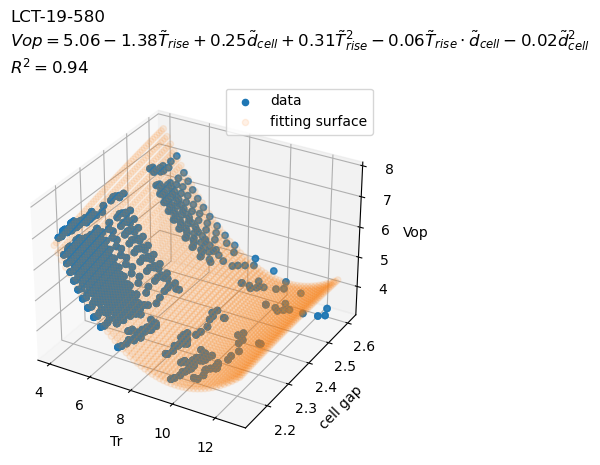

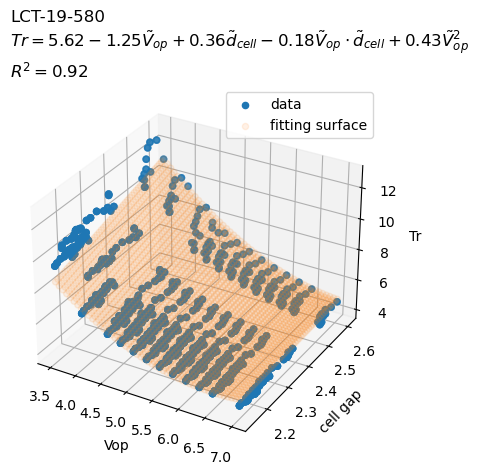

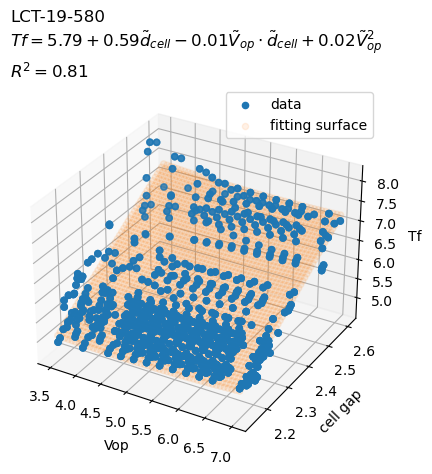

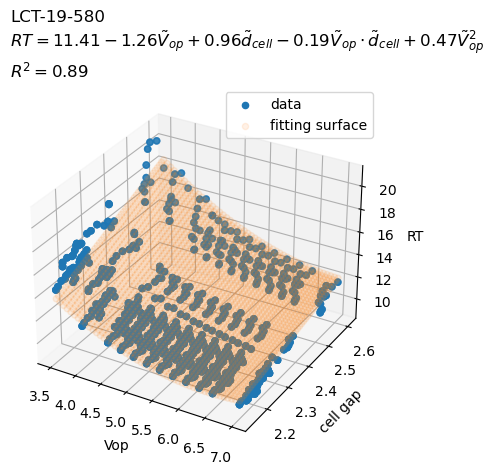

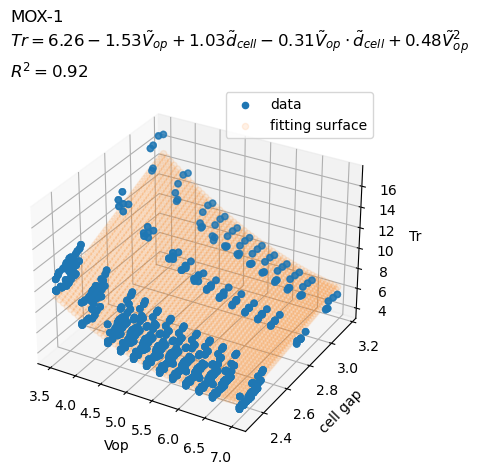

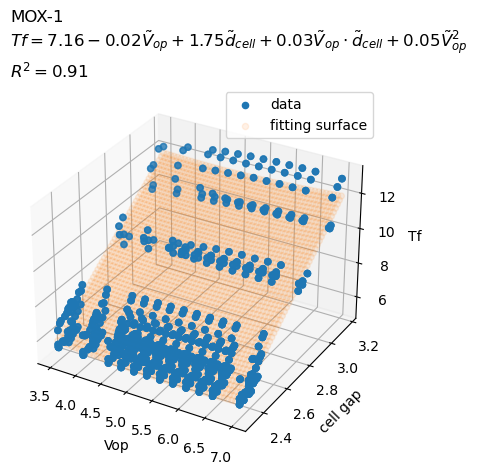

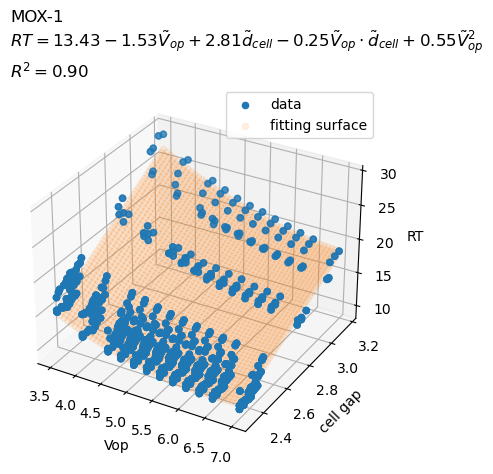

In [9]:
ref_Tr = ref["Tr(ms)"][0]
ref_cell_gap = ref["cell gap(um)"][0]
ref_LC = ref["LC"][0]

# check is there axo data
if len(axo) != 0:
    rt_cell_gap = pd.merge(rt, axo[["ID", "Point", "cell gap"]], how="left", on=["ID", "Point"])
else:
    rt_cell_gap = pd.merge(rt, rdl[["ID", "cell gap"]], how="left", on="ID")
    
df = rt_cell_gap[rt_cell_gap["LC"] == ref_LC].copy()
df["Tr"] = df["Rise-mean (10-90)"]
df["Vop"] = df["Target Vpk"]
plot_raw = df.copy()
df = df.groupby(by=["ID", "Vop", "Point"], as_index=False).mean()

# store all model in this dictionary
model = {}
# Let's try some fasion ML (XD
training_set, test_set = train_test_split(
    df,
    test_size = 0.2,
    random_state = 42
)
X_train = training_set[["Tr", "cell gap"]].to_numpy()
y_train = training_set["Vop"].to_numpy()
X_test = test_set[["Tr", "cell gap"]].to_numpy()
y_test = test_set["Vop"].to_numpy()
valid_data = [[ref_Tr, ref_cell_gap]]

# Linear regression

model["Vop_ref_LR"] = Pipeline([
    ('Scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('linear', linear_model.LinearRegression(fit_intercept=False))]
).fit(
    X_train, y_train,
)

# plot
aux_plot(
    plot_raw, ref_LC, ["Tr", "cell gap", "Vop"], 
    model["Vop_ref_LR"], 
    [
        '\\tilde{{T}}_{{rise}}', 
        '\\tilde{{d}}_{{cell}}', 
        '\\tilde{{T}}^2_{{rise}}', 
        '\\tilde{{T}}_{{rise}}\cdot\\tilde{{d}}_{{cell}}', 
        '\\tilde{{d}}_{{cell}}^2'
    ]
)

ref_Vop = float(model["Vop_ref_LR"].predict(valid_data))



# Calculate RT, Tf, Tr
df = rt_cell_gap.copy()
df["Vop"] = df["Target Vpk"]
df["RT"] = df["Rise-mean (10-90)"] + df["Fall-mean (10-90)"]
df["Tr"] = df["Rise-mean (10-90)"]
df["Tf"] = df["Fall-mean (10-90)"]
plot_raws = df.copy()
training_set, test_set = train_test_split(
    df,
    test_size = 0.1,
)

model["rt"] = {}

for LC in cond["LC"].unique():
    model["rt"][LC] = {}
    X_train = training_set[training_set["LC"]==LC][["Vop", "cell gap"]].to_numpy()
    X_test = test_set[test_set["LC"]==LC][["Vop", "cell gap"]].to_numpy()
    valid_data = [[ref_Vop, ref_cell_gap]]
    plot_raw = plot_raws[plot_raws["LC"]==LC]
    
    for item in ["Tr", "Tf", "RT"]:
        y_train = training_set[training_set["LC"]==LC][item].to_numpy()
        y_test = test_set[test_set["LC"]==LC][item].to_numpy()

        model["rt"][LC][f"{item}_LR"] = Pipeline([
            ('Scalar', StandardScaler()),
#             ('poly', PolynomialFeatures(degree=1)),
            ('Custom_Transformer', transformer),
            ('linear', linear_model.TheilSenRegressor(fit_intercept=False))
        ]).fit(
            X_train, y_train,
        )
        # plot
        aux_plot(
            plot_raw, LC, ["Vop", "cell gap", item], 
            model["rt"][LC][f"{item}_LR"], 
            [
                '\\tilde{{V}}_{{op}}', 
                '\\tilde{{d}}_{{cell}}', 
                '\\tilde{{V}}_{{op}}\cdot\\tilde{{d}}_{{cell}}', 
                '\\tilde{{V}}_{{op}}^2'
            ]
        )


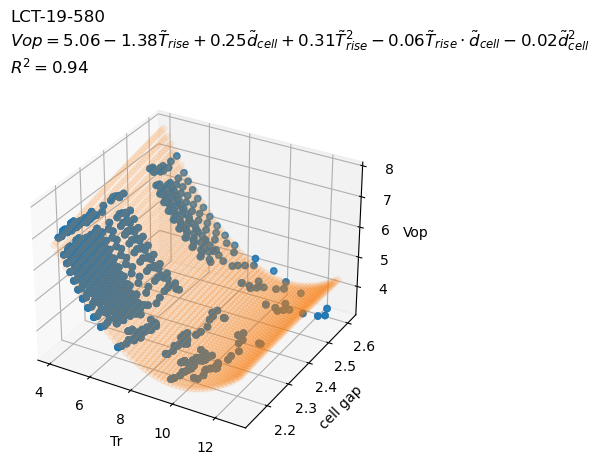

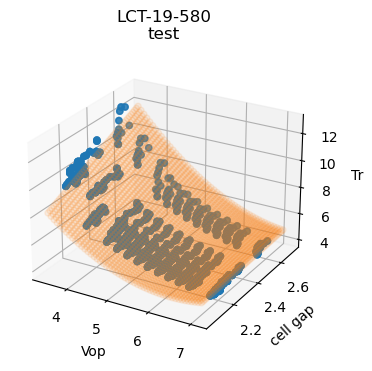

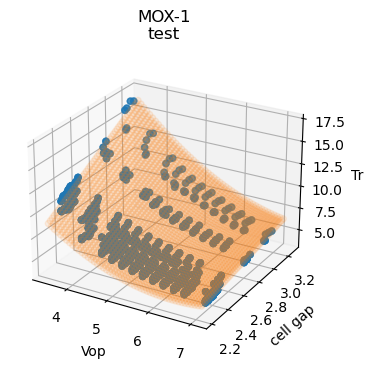

In [75]:
# plot for checking
# maybe plot_RT.py?
# %matplotlib widget # interact fig in notebook
import matplotlib.pyplot as plt
# ref Vop
coeff = model["Vop_ref_LR"].steps[2][1].coef_
R2 = 0.94
# raw
xlabel = "Tr"
ylabel = "cell gap"
zlabel = "Vop"
# plt.figure(figsize=(10,8))
ax = plt.axes(projection="3d")
plot_raw = df[df["LC"] == ref_LC]
ax.scatter(plot_raw[xlabel],plot_raw[ylabel],plot_raw[zlabel], label='raw')
# fitting
x_range = np.linspace(plot_raw[xlabel].min(), plot_raw[xlabel].max(), 50)
y_range = np.linspace(plot_raw[ylabel].min(), plot_raw[ylabel].max(), 50)
x_range, y_range = np.meshgrid(x_range, y_range)
predict_region = np.array(list(zip(x_range.flatten(), y_range.flatten())))
z_predict = model['Vop_ref_LR'].predict(predict_region)
ax.scatter(x_range, y_range, z_predict, label="fitting surface", alpha=0.1)
formula = tex_math_str(coeff, ['\\tilde{{T}}_{{rise}}', '\\tilde{{d}}_{{cell}}', '\\tilde{{T}}^2_{{rise}}', '\\tilde{{T}}_{{rise}}\cdot\\tilde{{d}}_{{cell}}', '\\tilde{{d}}_{{cell}}^2'])
plt.title(ref_LC + "\n$Vop=$" + formula + f"\n$R^2={R2:.2f}$", loc='left')
plt.legend
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)
plt.show()

# sample Tr
xlabel = "Vop"
ylabel = "cell gap"
zlabel = "Tr"
for LC in cond["LC"].unique():
    plt.figure(figsize=(5,4))
    ax = plt.axes(projection="3d")
    ax.view_init(25, -60)
    plot_raw = df[df["LC"] == LC]
    ax.scatter(plot_raw[xlabel],plot_raw[ylabel],plot_raw[zlabel], label=LC)
    # fitting
    x_range = np.linspace(plot_raw[xlabel].min()-0.1, plot_raw[xlabel].max()+0.1, 50)
    y_range = np.linspace(plot_raw[ylabel].min()-0.1, plot_raw[ylabel].max()+0.1, 50)
    x_range, y_range = np.meshgrid(x_range, y_range)
    predict_region = np.array(list(zip(x_range.flatten(), y_range.flatten())))
    z_predict = model["rt"][LC][f"Tr_LR"].predict(predict_region)
    ax.scatter(x_range, y_range, z_predict, label="fitting surface", alpha=0.1)
    plt.title(LC+"\ntest")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    plt.show()


In [143]:
from scipy.interpolate import interp1d
data = opt[(opt.ID=="T19BR001NL2X") & (opt.Point ==1)]
x = data["Voltage"]
y = data["LCM_Y%"]
f = interp1d(x, y, kind='cubic')
x_dense = np.linspace(0, 20, 1000)
y_dense = f(x_dense)

plt.figure(figsize=(5,4))
plt.plot(x_dense, y_dense, )


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
def opt_features_extract(X):
    # T%/LC% = a + b Vop + c Cell_gap + d Vop*Cell_gap + e Vop^2 + f Vop^3 + g Vop^4
    features = np.empty(shape=(len(X), 8), dtype=float)
    features[:, 0] = 1
    features[:, 1] = X[:, 0]
    features[:, 2] = X[:, 1]
    features[:, 3] = X[:, 1] ** 2
    features[:, 4] = X[:, 0] * X[:, 1]
    features[:, 5] = X[:, 0] ** 2
    features[:, 6] = X[:, 0] ** 3
    features[:, 7] = X[:, 0] ** 4

    return features
transformer_opt = FunctionTransformer(opt_features_extract)

In [11]:
def Vop_features_extract(X):
    # Vop = a + b * cell_gap + c * exp(T%+10)
    features = np.empty(shape=(len(X), 3), dtype=float)
    features[:, 0] = 1
#     features[:, 1] = X[:, 0]
    features[:, 1] = X[:, 1]
#     features[:, 3] = X[:, 0] * X[:, 1]
#     features[:, 4] = X[:, 0] ** 2
    features[:, 2] = np.exp(X[:, 0]+10)

    return features
transformer_Vop = FunctionTransformer(Vop_features_extract)

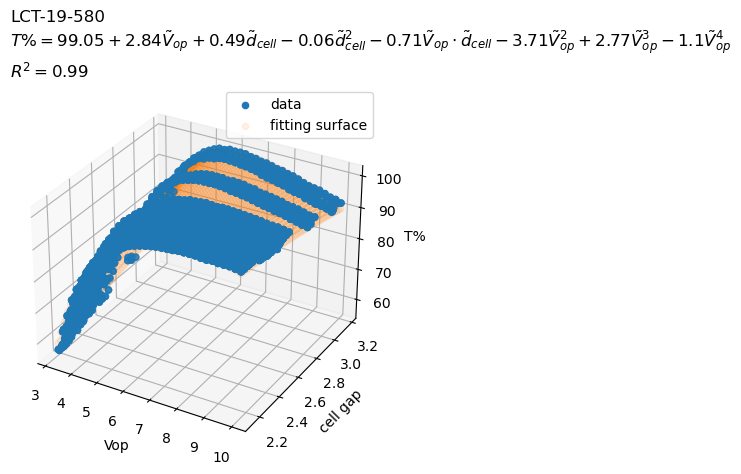

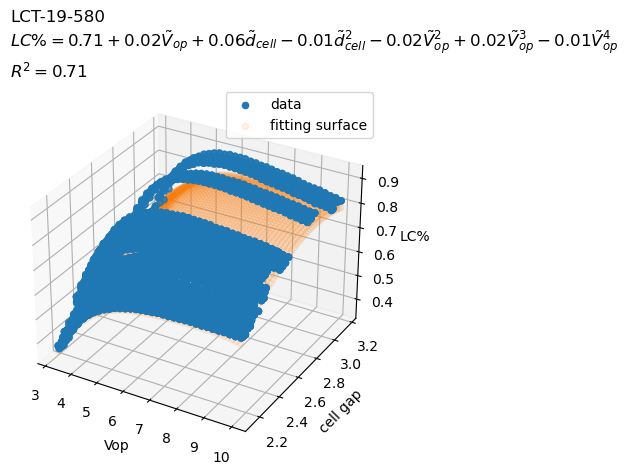

R2_test 0.91
LCT-19-580: Wx: 0.2691

R2_test 0.91
LCT-19-580: Wy: 0.2677

R2_test 0.89
LCT-19-580: WX: 582.7013

R2_test 0.90
LCT-19-580: WY: 575.8612

R2_test 0.86
LCT-19-580: WZ: 998.3989



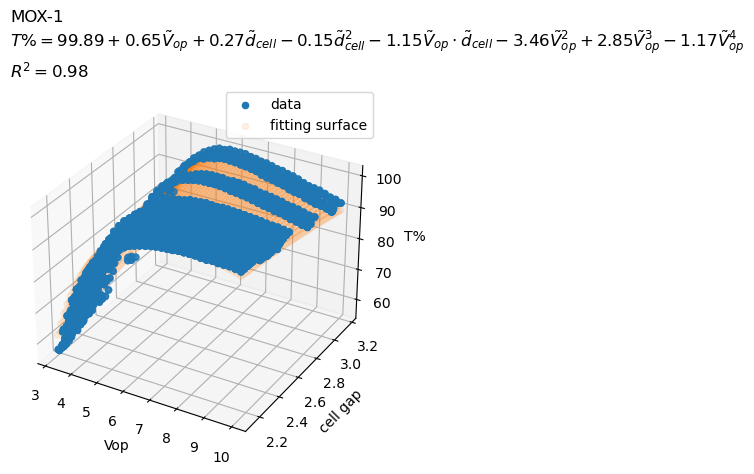

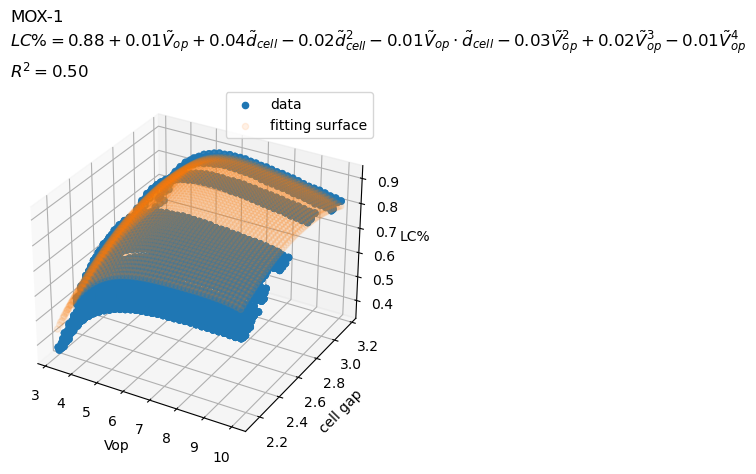

R2_test 0.95
MOX-1: Wx: 0.2900

R2_test 0.95
MOX-1: Wy: 0.2975

R2_test 0.81
MOX-1: WX: 632.1842

R2_test 0.83
MOX-1: WY: 648.5494

R2_test 0.87
MOX-1: WZ: 897.4331

R2_test 0.95
LCT-19-580: Vop: 4.4921

R2_test 0.95
MOX-1: Vop: 4.5298



In [12]:
# check is there axo data
if len(axo) != 0:
    opt_cell_gap = pd.merge(opt, axo[["ID", "Point", "cell gap"]], how="left", on=["ID", "Point"])
else:
    opt_cell_gap = pd.merge(opt, rdl[["ID", "cell gap"]], how="left", on="ID")

model["opt"] = {}
df = opt_cell_gap.copy()
# some mapping and rename
df["T%"] = opt_cell_gap.groupby(by=["ID", "Point"])["LCM_Y%"].apply(lambda x: 100*x / float(x.max()))
df["Vop"] = df["Voltage"]/2.0
df["LC%"] = df["LCM_Y%"]
df["Wx"] = df["W_x"]
df["Wy"] = df["W_y"]
# the varient is large when Vop is low, so I cut-off at Vop = 2
df = df[df["Vop"] > 3]
plot_raw = df.copy()
training_set, test_set = train_test_split(
    df,
    test_size = 0.2,
#     random_state = 42
)

for LC in cond["LC"].unique():
    model["opt"][LC] = {}
    X_train = training_set[training_set["LC"]==LC][["Vop", "cell gap"]].to_numpy()
    X_test = test_set[test_set["LC"]==LC][["Vop", "cell gap"]].to_numpy()
    valid_data = [[ref_Vop, ref_cell_gap]]
    for item in ["T%", "LC%"]:
        y_train = training_set[training_set["LC"]==LC][item].to_numpy()
        y_test = test_set[test_set["LC"]==LC][item].to_numpy()
        model["opt"][LC][f'{item}_LR'] = Pipeline([
            ('Scalar', StandardScaler()),
#             ('poly', PolynomialFeatures(degree=2)),
            ('Custom_Transformer', transformer_opt),
            ('linear', linear_model.TheilSenRegressor(fit_intercept=False)),
#             ('linear', linear_model.LinearRegression(fit_intercept=False)),
#             ("GR", GaussianProcessRegressor(kernel=DotProduct()+WhiteKernel()))
        ]).fit(
            X_train, y_train,
        )
        # plot
        aux_plot(
            plot_raw, LC, ["Vop", "cell gap", item], 
            model["opt"][LC][f'{item}_LR'], 
            [
                '\\tilde{{V}}_{{op}}', 
                '\\tilde{{d}}_{{cell}}', 
                '\\tilde{{d}}_{{cell}}^2', 
                '\\tilde{{V}}_{{op}}\cdot\\tilde{{d}}_{{cell}}', 
                '\\tilde{{V}}_{{op}}^2',
                '\\tilde{{V}}_{{op}}^3',
                '\\tilde{{V}}_{{op}}^4'
            ]
        )
    for item in ["Wx", "Wy", "WX", "WY", "WZ"]:
        y_train = training_set[training_set["LC"]==LC][item].to_numpy()
        y_test = test_set[test_set["LC"]==LC][item].to_numpy()
        model["opt"][LC][f'{item}_LR'] = Pipeline([
            ('Scalar', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2)),
#             ('Custom_Transformer', transformer),
            ('linear', linear_model.TheilSenRegressor(fit_intercept=False))
        ]).fit(
            X_train, y_train,
        )
        print(f'R2_test {model["opt"][LC][f"{item}_LR"].score(X_test, y_test):.2f}')
        ans = float(model["opt"][LC][f"{item}_LR"].predict(valid_data))
        print(f"{LC}: {item}: {ans:.4f}")
        print()

# find V%
# f(T%, cell_gap) -> V%

# make a cut off opt data
opt_cutoff = pd.DataFrame(columns=opt.columns)
for ID in df.ID.unique():
    for Point in df.Point.unique():
        tmp_df = df[(df.ID == ID) & (df.Point == Point)]
        tmp_df = tmp_df.iloc[:tmp_df["LCM_Y%"].argmax(),:]
        opt_cutoff = pd.concat([opt_cutoff, tmp_df])
training_set, test_set = train_test_split(
    opt_cutoff,
    test_size = 0.2,
#     random_state = 42
)
valid_data = [[90.0, ref_cell_gap]]
training_set_Vop = training_set[training_set["T%"]>89]
test_set_Vop = test_set[test_set["T%"]>89]

for LC in cond["LC"].unique():
    X_train = training_set_Vop[training_set_Vop["LC"]==LC][["T%", "cell gap"]].to_numpy()
    X_test = test_set_Vop[test_set_Vop["LC"]==LC][["T%", "cell gap"]].to_numpy()
    y_train = training_set_Vop[training_set_Vop["LC"]==LC]["Vop"].to_numpy()
    y_test = test_set_Vop[test_set_Vop["LC"]==LC]["Vop"].to_numpy()
    model["opt"][LC][f'Vop_LR'] = Pipeline([
        ('Scalar', StandardScaler()),
#         ('poly', PolynomialFeatures(degree=6)),
        ('Custom_Transformer', transformer_Vop),
        ('linear', linear_model.TheilSenRegressor(fit_intercept=False)),
#         ('linear', linear_model.Linsor(kernel=DotProduct()+WhiteKernel()))
    ]).fit(
        X_train, y_train,
    )
    print(f'R2_test {model["opt"][LC][f"Vop_LR"].score(X_test, y_test):.2f}')
    ans = float(model["opt"][LC][f"Vop_LR"].predict(valid_data))
    print(f"{LC}: Vop: {ans:.4f}")
    print()

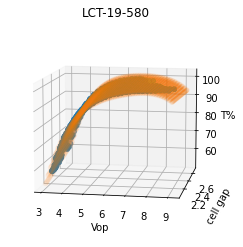

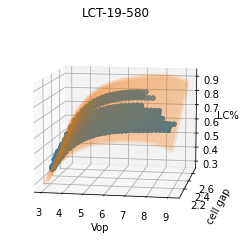

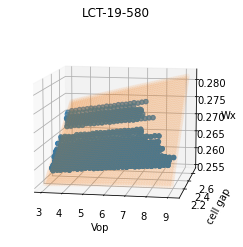

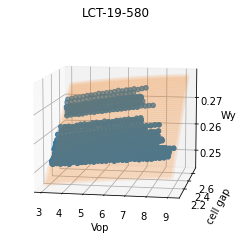

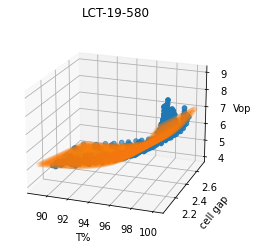

In [32]:
# plot for checking
# maybe plot_RT.py?
# %matplotlib widget
import matplotlib.pyplot as plt

# sample Tr
xlabel = "Vop"
ylabel = "cell gap"
for item in ["T%", "LC%", "Wx", "Wy"]:
    zlabel = item
#     for LC in cond["LC"].unique():
    for LC in [cond["LC"].unique()[0]]:
        plt.figure(figsize=(5,4))
        ax = plt.axes(projection="3d")
        ax.view_init(10, -80)
        plot_raw = df[df["LC"] == LC]
        ax.scatter(plot_raw[xlabel],plot_raw[ylabel],plot_raw[zlabel], label=LC)
        # fitting
        x_range = np.linspace(plot_raw[xlabel].min()-0.1, plot_raw[xlabel].max()+0.1, 50)
        y_range = np.linspace(plot_raw[ylabel].min()-0.1, plot_raw[ylabel].max()+0.1, 50)
        x_range, y_range = np.meshgrid(x_range, y_range)
        predict_region = np.array(list(zip(x_range.flatten(), y_range.flatten())))
        z_predict = model["opt"][LC][f"{item}_LR"].predict(predict_region)
        ax.scatter(x_range, y_range, z_predict, label="fitting surface", alpha=0.05)
        plt.title(LC)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_zlabel(zlabel)
        plt.show()

plot_raw = df[df["LC"] == LC]
plot_raw = plot_raw[plot_raw["T%"]>89]
xlabel = "T%"
ylabel = "cell gap"
zlabel = "Vop"
plt.figure(figsize=(5,4))
ax = plt.axes(projection="3d")
ax.view_init(20, -70)
ax.scatter(plot_raw[xlabel],plot_raw[ylabel],plot_raw[zlabel], label=LC)
# fitting
x_range = np.linspace(plot_raw[xlabel].min()-0.1, plot_raw[xlabel].max()+0.1, 50)
y_range = np.linspace(plot_raw[ylabel].min()-0.1, plot_raw[ylabel].max()+0.1, 50)
x_range, y_range = np.meshgrid(x_range, y_range)
predict_region = np.array(list(zip(x_range.flatten(), y_range.flatten())))
z_predict = model["opt"][LC][f"Vop_LR"].predict(predict_region)
ax.scatter(x_range, y_range, z_predict, label="fitting surface", alpha=0.1)
plt.title(LC)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)
plt.show()

In [28]:
# Generate table
summary_table = pd.DataFrame(
    columns=["Batch", "LC", "V90", "V95", "V99", "Vmax", "Vop(V)", "Δnd(nm)", "Gap(um)", "LC%", "Wx", "Wx_gain", "Wy", "Wy_gain",
             "u'", "v'", "Δ(u', v')", "a*", "b*", "L*", "Δa*", "Δb*", "ΔL*", "ΔEab*", "CR", "ΔCR(%)", "T%", "Scatter", "D", "W", 
             "Tr(ms)", "Tf(ms)", "RT(ms)", "G2G(ms)", "remark"]
)
# cell gap range
# +- 0.5 um, precise to 0.1 um
center_cell_gap = np.round(ref_cell_gap, decimals=1)
cell_gap_range = np.linspace(center_cell_gap-0.5, center_cell_gap+0.5, 11)

# for Eab
def F(X, opt):
    BLU = {
        "Xn": 95.04,
        "Yn": 100.00,
        "Zn": 108.86
    }
    result = 7.787 * X/BLU[opt] + 16/116
    result = result if X/BLU[opt] < 0.008856 else (X/BLU[opt]) ** (1/3)
    return result

# CR
X = [[ref_Vop, ref["cell gap(um)"][0]]]
ref_LC = ref["LC"][0]
ref_CR = ref["CR"][0]
ref_CR_index = ref_CR / (model["opt"][ref_LC]["T%_LR"].predict(X)[0]/float(prop[prop["LC"] == ref_LC]["Scatter index"])/ref["cell gap(um)"][0])
        
for LC in cond["LC"].unique():
    # cell gap
    if len(axo) != 0:
        max_cell_gap = axo[axo["LC"] == LC]["cell gap"].max()
        min_cell_gap = axo[axo["LC"] == LC]["cell gap"].min()        
    else:
        max_cell_gap = rdl[rdl["LC"] == LC]["cell gap"].max()
        min_cell_gap = rdl[rdl["LC"] == LC]["cell gap"].min()  

    ne = float(prop[prop["LC"] == LC]["n_e"])
    no = float(prop[prop["LC"] == LC]["n_o"])
    scatter_index = float(prop[prop["LC"] == LC]["Scatter index"])
    for cell_gap in cell_gap_range:
        summary_table = summary_table.append({"LC": LC, "Gap(um)": cell_gap}, ignore_index=True)
        # rt
        X = [[ref_Vop, cell_gap]]
        X_minus = [[ref_Vop, cell_gap - 0.1]]
        Tr = model["rt"][LC]["Tr_LR"].predict(X)
        Tf = model["rt"][LC]["Tf_LR"].predict(X)
        RT = model["rt"][LC]["RT_LR"].predict(X)
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "RT(ms)"] = RT[0]
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "Tr(ms)"] = Tr[0]
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "Tf(ms)"] = Tf[0]
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "G2G(ms)"] = ref["G2G(ms)"][0] / ref["RT(ms)"][0] * RT[0]

        # opt
        Wx = model["opt"][LC]["Wx_LR"].predict(X)
        Wx_gain = Wx - ref["Wx"][0]
        Wy = model["opt"][LC]["Wy_LR"].predict(X)
        Wy_gain = Wy - ref["Wy"][0]
        T = model["opt"][LC]["T%_LR"].predict(X)
        LCp = model["opt"][LC]["LC%_LR"].predict(X)
        Δnd = (ne - no) * cell_gap * 1000
 
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "Wx"] = Wx[0]
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "Wx_gain"] = Wx_gain[0]
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "Wy"] = Wy[0]
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "Wy_gain"] = Wy_gain[0]
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "T%"] = T[0]
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "LC%"] = LCp[0] * 100
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "Δnd(nm)"] = Δnd
        
        WX = model["opt"][LC]["WX_LR"].predict(X)
        WY = model["opt"][LC]["WY_LR"].predict(X)
        WZ = model["opt"][LC]["WZ_LR"].predict(X)

        Wx_minus = model["opt"][LC]["Wx_LR"].predict(X_minus)
        Wy_minus = model["opt"][LC]["Wy_LR"].predict(X_minus)
        WX_minus = model["opt"][LC]["WX_LR"].predict(X_minus)
        WY_minus = model["opt"][LC]["WY_LR"].predict(X_minus)
        WZ_minus = model["opt"][LC]["WZ_LR"].predict(X_minus)

        # another way to reproduce WX, WZ from xyY
#         WX = [Wx[0] * WY[0] / Wy[0]]
#         WZ = [(1 - Wx[0] - Wy[0]) * WY[0] / Wy[0]]
        
        F_X = F(WX[0], "Xn")
        F_Y = F(WY[0], "Yn")
        F_Z = F(WZ[0], "Zn")
        a_star = 500 * (F_X - F_Y)
        b_star = 200 * (F_Y - F_Z)
        L_star = 116 * F_Y - 16
        u_prime = 4 * Wx[0] / (-2 * Wx[0] + 12 * Wy[0] + 3)
        v_prime = 9 * Wy[0] / (-2 * Wx[0] + 12 * Wy[0] + 3)
        
        F_X_minus = F(WX_minus[0], "Xn")
        F_Y_minus = F(WY_minus[0], "Yn")
        F_Z_minus = F(WZ_minus[0], "Zn")
        a_star_minus = 500 * (F_X_minus - F_Y_minus)
        b_star_minus = 200 * (F_Y_minus - F_Z_minus)
        L_star_minus = 116 * F_Y_minus - 16
        Δa_star = a_star - a_star_minus
        Δb_star = b_star - b_star_minus
        ΔL_star = L_star - L_star_minus
        ΔE_ab_star = (Δa_star**2 + Δb_star**2 + ΔL_star**2)**(1/2)
        u_prime_minus = 4 * Wx_minus[0] / (-2 * Wx_minus[0] + 12 * Wy_minus[0] + 3)
        v_prime_minus = 9 * Wy_minus[0] / (-2 * Wx_minus[0] + 12 * Wy_minus[0] + 3)
        Δuv = ((u_prime - u_prime_minus)**2 + (v_prime - v_prime_minus)**2)**(1/2)
        
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "a*"] = a_star
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "b*"] = b_star
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "L*"] = L_star
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "Δa*"] = Δa_star
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "Δb*"] = Δb_star
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "ΔL*"] = ΔL_star
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "ΔEab*"] = ΔE_ab_star

        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "u'"] = u_prime
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "v'"] = v_prime
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "Δ(u', v')"] = Δuv

        # V%
        V90 = model["opt"][LC]["Vop_LR"].predict([[90, cell_gap]])
        V95 = model["opt"][LC]["Vop_LR"].predict([[95, cell_gap]])
        V99 = model["opt"][LC]["Vop_LR"].predict([[99, cell_gap]])
        Vmax = model["opt"][LC]["Vop_LR"].predict([[100, cell_gap]])
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "V90"] = V90[0]
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "V95"] = V95[0]
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "V99"] = V99[0]
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "Vmax"] = Vmax[0]
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "Vop(V)"] = ref_Vop
        
        # CR
        Scatter = scatter_index * cell_gap
        D = Scatter
        W = T[0]
        CR = W/D * ref_CR_index
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "D"] = D
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "W"] = W
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "Scatter"] = Scatter
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "CR"] = CR
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "ΔCR(%)"] = (CR-ref_CR)/ref_CR * 100
        
        remark = "Interpolation" if ((max_cell_gap > cell_gap) & (min_cell_gap < cell_gap)) else "Extrapolation"
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "remark"] = remark
        
        summary_table.loc[((summary_table["LC"] == LC) & (summary_table["Gap(um)"] == cell_gap)), "Batch"] = batch




In [29]:
summary_table[["Batch", "LC", "Gap(um)", "remark"]]

,Batch,LC,Gap(um),remark
0,RD11006008,LCT-19-580,2.0,Extrapolation
1,RD11006008,LCT-19-580,2.1,Extrapolation
2,RD11006008,LCT-19-580,2.2,Interpolation
3,RD11006008,LCT-19-580,2.3,Interpolation
4,RD11006008,LCT-19-580,2.4,Interpolation
5,RD11006008,LCT-19-580,2.5,Interpolation
6,RD11006008,LCT-19-580,2.6,Interpolation
7,RD11006008,LCT-19-580,2.7,Extrapolation
8,RD11006008,LCT-19-580,2.8,Extrapolation
9,RD11006008,LCT-19-580,2.9,Extrapolation


In [2]:
# query_total_table.py
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy as sql
import os

# params_str = {
#     "LC": sys.argv[1],
#     "cell_gap_lower": sys.argv[2],
#     "cell_gap_upper": sys.argv[3],
# }
# test input
params_str = {
    "LC": "LCT-15-1098,SLC19V33L00",
    "cell_gap_lower": "2.8,2.8",
    "cell_gap_upper": "3.4,3.4",
}

engine = sql.create_engine('sqlite:///./database/test.db', echo=False)

params = {}
for k, v in params_str.items():
    params[k] = v.split(",")

# print(os.getcwd())

result_df = pd.DataFrame()
# output = './public/tmp/'
output = './tmp/'
rnd_file_code = f"-{np.random.randint(0, 10000):04d}"
file_name = output + 'query-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime()) + rnd_file_code
for i in range(len(params["LC"])):
    print(params['LC'][i])
    tmp_df = pd.read_sql(f"SELECT * FROM summary WHERE LC == \"{params['LC'][i]}\" AND \"Gap(um)\" > {params['cell_gap_lower'][i]} AND \"Gap(um)\" < {params['cell_gap_upper'][i]}", engine)
    result_df = pd.concat([result_df, tmp_df], ignore_index=True)

result_df.to_excel(file_name + '.xlsx')

# print(params)
print(file_name + ".xlsx")
# print('python finished')

LCT-15-1098
SLC19V33L00
./tmp/query-2021-08-11-07-35-03-4018.xlsx


In [102]:
# reading property table test
# for now it's just messy trash...
pd.read_excel("old_ref/20200924_液晶data sheet (總整理) .xlsx",sheet_name="量產負型AAS",index_col=False)

,產品,*,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Mobile,Mobile.1,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,NB,Unnamed: 22,Unnamed: 23
0,Type,*,AAS,NaN,AAS,NaN,AAS,NaN,AAS,AAS,...,AAS,NaN,AAS,AAS,AAS,NaN,NaN,AAS,NaN,NaN
1,LC Name,*,LCT-13-1386,NaN,LCT-16-1381,NaN,LCT-15-1098,NaN,ZYH-7013XX,LCT-16-1228,...,LCT-16-1381,NaN,LCT-17-1336,LCT-19-580,SLC19V33L00,LCT-16-1200,ZIX-7244XX,LCT-19-1113,NaN,NaN
2,廠區,*,"南廠, T1",NaN,T3,NaN,T1,NaN,L6,T6,...,T3,NaN,T6/T3/T2,T6,NaN,NaN,NaN,NaN,NaN,NaN
3,廠商,NaN,Merck,NaN,Merck,NaN,Merck,NaN,JNC,Merck,...,Merck,NaN,Merck,Merck,SliChem,Merck,JNC,Merck,NaN,NaN
4,廠商量測LC溫度(℃),NaN,20,25.000000,20,25.000000,20,25.000000,25,20,...,20,25.000000,25,25,25,25,25,20,25.000000,30.000000
5,Transition Temp.,Tni(℃),84.5,NaN,84.9,84.900000,85.2,85.200000,80,78.2,...,84.9,84.900000,84.6,79.4,79.9,91.1,NaN,77.8,NaN,NaN
6,NaN,Tcn(℃),-30,-30.000000,NaN,NaN,-30,-30.000000,<-30,-30,...,-30,-30.000000,-30,-30,-30,-20,-15,NaN,NaN,NaN
7,cell Gap (um),NaN,NaN,3.100000,2.8,2.800000,3.1,3.100000,3.2,3.2,...,2.8,2.800000,2.8,3,2.8,3.65,3.65,3.2,3.200000,3.200000
8,d*△n (um),NaN,NaN,0.294810,0.29904,0.293720,0.30256,0.298220,0.32,0.32512,...,0.29904,0.293720,0.3234,0.3201,0.32228,0.309885,NaN,0.30848,0.302080,0.295680
9,Optical Anisotropy (589....,ne,1.5774,1.574100,1.5905,1.587200,1.5794,1.576900,1.586,1.5832,...,1.5905,1.587200,1.6015,1.5925,1.6028,1.563,NaN,1.5776,1.574300,1.571100


In [1]:
# test zip files in one folder
import shutil
shutil.make_archive('./tmp/test', 'zip', './test_img')

'F:\\dimsp\\Documents\\Projects\\nodejsLearning\\tdtoolkit_web\\tmp\\test.zip'

In [19]:
# Save model
# using pickle

import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)
# Fit the model on training set
model = LogisticRegression()
model.fit(X_train, Y_train)
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

0.7874015748031497


F:\opt\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
